
### The Notebook Contains:
* EDA
  * Contains the bar graph to analyze the flight cancellation for different airlines. 
  * Contains the bar graph to analyze the flight cancellation in different months. 

* Machine Learning
  * Using Logistic regression, Random forest classifier and GBT classifier for prediction of flight cancellation.

### Objective
* To develop machine learning models that classify flights outcome (cancelled or not cancelled) with selected attributes.
* To evaluate performance of different machine learning models.

### Approach
* Used <em><strong>Logistic Regression</strong></em>, <em><strong>Random Forest Classifier</em></strong> and <em><strong>GBT Classifier</em></strong> for prediction and compared  
  these models to find the Best 
  Model.

### Dataset
* The Datasource is from Kaggle , can be found [here.]("https://nam12.safelinks.protection.outlook.com/?url=https%3A%2F%2Fwww.kaggle.com%2Fdatasets%2Fyuanyuwendymu%2Fairline-delay-and-cancellation-data-2009-2018%2Fdata&data=05%7C01%7Cdghate1%40student.gsu.edu%7Cd6e6b5058c0a4fe4865a08dbd9760ff0%7C704d822c358a47849a1649e20b75f941%7C0%7C0%7C638342873335688264%7CUnknown%7CTWFpbGZsb3d8eyJWIjoiMC4wLjAwMDAiLCJQIjoiV2luMzIiLCJBTiI6Ik1haWwiLCJXVCI6Mn0%3D%7C3000%7C%7C%7C&sdata=Gz%2FsLKnCm9zZ6bIalK%2BoDJojg5ENjCuR3%2FWJeFYgd9M%3D&reserved=0")



### Import packages 

In [0]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

import pyspark.sql.functions as F
import pyspark.sql.types as T 
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

### Download Airline Data 

In [0]:

!wget https://downloable.s3.amazonaws.com/2017.csv
#!wget https://downloable.s3.amazonaws.com/2018.csv
# !ls



--2023-12-10 04:05:00--  https://downloable.s3.amazonaws.com/2017.csv
Resolving downloable.s3.amazonaws.com (downloable.s3.amazonaws.com)... 3.5.28.46, 3.5.28.235, 3.5.29.148, ...
Connecting to downloable.s3.amazonaws.com (downloable.s3.amazonaws.com)|3.5.28.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 702257855 (670M) [text/csv]
Saving to: ‘2017.csv’

2017.csv            100%[===================>] 669.72M  41.6MB/s    in 19s     

2023-12-10 04:05:20 (34.4 MB/s) - ‘2017.csv’ saved [702257855/702257855]



In [0]:
# initialize sparkSession
spark = SparkSession.builder.appName("Flight Delays").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

### Load Data 

In [0]:
file_path = "file:/databricks/driver/2017.csv"

schema = T.StructType([
    T.StructField("FL_DATE", T.TimestampType(), nullable=True),
    T.StructField("OP_CARRIER", T.StringType(), nullable=True),
    T.StructField("OP_CARRIER_FL_NUM", T.IntegerType(), nullable=True),
    T.StructField("ORIGIN", T.StringType(), nullable=True),
    T.StructField("DEST", T.StringType(), nullable=True),
    T.StructField("CRS_DEP_TIME", T.DoubleType(), nullable=True),
    T.StructField("DEP_TIME", T.DoubleType(), nullable=True),
    T.StructField("DEP_DELAY", T.DoubleType(), nullable=True),
    T.StructField("TAXI_OUT", T.DoubleType(), nullable=True),
    T.StructField("WHEELS_OFF", T.DoubleType(), nullable=True),
    T.StructField("WHEELS_ON", T.DoubleType(), nullable=True),
    T.StructField("TAXI_IN", T.DoubleType(), nullable=True),
    T.StructField("CRS_ARR_TIME", T.DoubleType(), nullable=True),
    T.StructField("ARR_TIME",T.DoubleType(), nullable=True),
    T.StructField("ARR_DELAY", T.DoubleType(), nullable=True),
    T.StructField("CANCELLED", T.DoubleType(), nullable=True),
    T.StructField("CANCELLATION_CODE", T.StringType(), nullable=True),
    T.StructField("DIVERTED", T.DoubleType(), nullable=True),
    T.StructField("CRS_ELAPSED_TIME", T.DoubleType(), nullable=True),
    T.StructField("ACTUAL_ELAPSED_TIME", T.DoubleType(), nullable=True),
    T.StructField("AIR_TIME", T.DoubleType(), nullable=True),
    T.StructField("DISTANCE", T.DoubleType(), nullable=True),
    T.StructField("CARRIER_DELAY", T.DoubleType(), nullable=True),
    T.StructField("WEATHER_DELAY", T.DoubleType(), nullable=True),
    T.StructField("NAS_DELAY", T.DoubleType(), nullable=True),
    T.StructField("SECURITY_DELAY", T.DoubleType(), nullable=True),
    T.StructField("LATE_AIRCRAFT_DELAY", T.DoubleType(), nullable=True),
    T.StructField("Unnamed: 27", T.StringType(), nullable=True)
])

flights_df = spark.read.schema(schema).format("csv").option("header", "true").load(file_path)
#flights_df.select(F.col("CANCELLED")).distinct().show()
#flights_df = flights_df.limit(1000)
flights_df.printSchema()


root
 |-- FL_DATE: timestamp (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: double (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: double (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: d

In [0]:
display(flights_df)

### Data Explanation
<ul>
 
<b><li>FL_DATE : the date of the flight.</li></b>
<li>OP CARRIER : the airline identifier.</li>
<b><li>OP_CARRIER_FL_NUM : the flight number.</li></b>
<b><li>ORIGIN : the starting airport code.</li></b>
<b><li>DEST : the destination airport code.</li></b>
<li>CRS_DEP_TIME : the planned departure time.</li>
<li>DEP_TIME : the actual departure time.</li>
<li>DEP_DELAY : the total delay on departure in minutes.</li>
<li>TAXI_OUT : the time duration elapsed between departure from the origin airport gate and wheels off.</li>
<li>WHEELS_OFF : the time point that the aircraft's wheels leave the ground.</li>
<li>WHEELS_ON : the time point that the aircraft's wheels touch on the ground.</li>
<li>TAXI_IN : the time duration elapsed between wheels-on and gate arrival at the destination airport.</li>
<b><li>CRS ARR TIME : the planned arrival time.</li></b>
<li>ARR_TIME : the actual arrival time.</li>
<li>ARR_DELAY : the total delay on arrival in minutes.</li></b>
<b><i><li>CANCELLED : indicates whether the flight was cancelled (1 = cancelled).</li></i></b>
<li>CANCELLATION_CODE : indicates the reason for cancellation of flight (A - Airline/Carrier, B - Weather, C - National Air System, D - Security).</li>
<b><li>DIVERTED : indicates whether the aircraft landed on a different airport than the one scheduled (1 = diverted).</li></b>
<b><li>CRS_ELAPSED_TIME : is the planned time amount needed for the flight trip.</li></b>
<li>ACTUAL ELAPSED TIME : is the actual time it took to complete the flight trip.</li>
<li>AIR_TIME : is the time duration between wheels_off and wheels_on time.</li>
<li>DISTANCE : is the distance between the two airports.</li>
<li>CARRIER_DELAY : is the delay caused by the airline in minutes.</li>
<li>WEATHER DELAY : is the delay caused by weather.</li>
<li>NAS_DELAY : is the delay caused by the air system.</li>
<li>SECURITY_DELAY : is the delay caused by security reasons.</li>
<li>LATE AIRCRAFT DELAY : is the delay caused by the aircraft being late.</li>
 
</ul>

### Cleaning Data And Preprocessing 

 * Removed null values to improve the accuracy of the classification model.
 * Dropped columns that indirectly indicate cancelled flights, as most flights with null values are cancelled anyway.
 * Took a subset of the data with subsampling to balance the dataset, as the number of cancelled flights is much smaller than the number  
   of non-cancelled flights.

In [0]:
print("rows: {}".format(flights_df.count()))
#Drop NULL Values
flights_df = flights_df.dropna(subset = [
    'FL_DATE',
 'OP_CARRIER',
 'OP_CARRIER_FL_NUM',
 'ORIGIN',
 'DEST',
 'CRS_DEP_TIME',
 'CRS_ARR_TIME',
 'CANCELLED',
 'DIVERTED',
 'CRS_ELAPSED_TIME',
 'DISTANCE'])

print("rows after dropna",format(flights_df.count()))

visualisation_df = flights_df.toPandas()


rows: 5674621
rows after dropna 5674614


In [0]:
#Remove columns indirectly indicating flight cancellation to prevent data leakage.
#These columns are null most of the cancelled flights.

flights_df = flights_df.drop("Unnamed: 27", 
                        "CARRIER_DELAY", 
                        "WEATHER_DELAY",
                        "NAS_DELAY",
                        "SECURITY_DELAY",
                        "LATE_AIRCRAFT_DELAY",
                        "CANCELLATION_CODE",
                        "DEP_TIME",
                        "DEP_DELAY",
                        "TAXI_OUT",
                        "WHEELS_OFF",
                        "WHEELS_ON",
                        "TAXI_IN",
                        "ARR_TIME",
                        "ARR_DELAY",
                        "ACTUAL_ELAPSED_TIME", 
                        "AIR_TIME")

In [0]:
null_columns = [col_name for col_name in flights_df.columns if flights_df.filter(F.col(col_name).isNull() |(F.col(col_name) == "")  ).count() > 0]

# Display columns with null values
if null_columns:
    print("Columns with null values:", null_columns)
else:
    print("No columns have null values.")

No columns have null values.


In [0]:
#Checking balance of the data
cancelled_count = flights_df.groupBy(F.col("CANCELLED")).count()
print(cancelled_count.show())

+---------+-------+
|CANCELLED|  count|
+---------+-------+
|      0.0|5591928|
|      1.0|  82686|
+---------+-------+

None


* Most ML models assume uniformly distirbuted data
# Imbalance data strategies
https://www.kdnuggets.com/2020/01/5-most-useful-techniques-handle-imbalanced-datasets.html
* Random Undersampling and Oversampling
* Undersampling and Oversampling using imbalanced-learn
* **Class weights in the models**
  * Adjust the weights inversely proportional to class frequencies in the input data
  * https://vitalflux.com/class-imbalance-class-weight-python-sklearn
  * n_samples / (n_classes * np.bincount(y))
    * n_sample / (n_classes * count_of_class(i)) = w(i)
* Change your Evaluation Metric

**Weights**

* https://techcommunity.microsoft.com/t5/ai-machine-learning-blog/dealing-with-imbalanced-data-in-automl/ba-p/1625043
* 3 classes for 9 rows of data
  * cats are 9 / (3 * 3) = 1.0
  * dogs are 9 / (3 * 5) = 0.6
  * horses are 9 / (3 * 1) = 3.0

<img src="https://techcommunity.microsoft.com/t5/image/serverpage/image-id/215809i0E3E0E2325ADA3D5/image-dimensions/831x447?v=v2" width="900">


In [0]:
def class_weights(df:flights_df, column='CANCELLED'):
  """
  Compute rebalancing weights for the given `column`.
  """
  class_counts = list(df.groupBy(column).count().toPandas().to_dict(orient='list').values())
  num_classes = len(class_counts[0])
  total_samples = sum(class_counts[1])
  pairs = list(zip(class_counts[0], class_counts[1]))
  return {k:total_samples/(num_classes * v) for (k, v) in pairs}

def weight_column(classes: pd.Series, class_weights) -> pd.Series:
  """
  UDF to compute class weights.
  Parameter `class_weights` is the pre-computed class_weights.
  Example call: sdf.withColumn('weight', weight_column(sdf['Class'], class_weights(sdf, column='Class')))
  """

  @F.pandas_udf(T.DoubleType())
  def weight_column_udf(classes: pd.Series) -> pd.Series:
    """
    UDF to compute rebalancing weights for the given `classes` (as a column).
    Depends on the within lexically scoped variable, class_weights, which contains a dictionary of weights.
    Relies on pre-computed class_weights (because cannot depend on pandas_udf to run over entire column in 1 batch)
    """
    result = []
    for _, value in classes.items():
      result += [class_weights[value]]
    return pd.Series(result)
  
  return weight_column_udf(classes)

In [0]:
print(f"The Class weights are {class_weights(flights_df)}")

The Class weights are {0.0: 0.507393335536509, 1.0: 34.31423699296133}


In [0]:
df_weighted = flights_df.withColumn('weight', weight_column(flights_df['CANCELLED'], class_weights(flights_df)))
display(df_weighted.groupBy('CANCELLED', 'weight').agg(F.count('CANCELLED').alias('count')))

CANCELLED,weight,count
0.0,0.507393335536509,5591928
1.0,34.31423699296133,82686


## Exploratory Data Analysis (EDA)
* Using Bar Charts to Indicate the cancellation of Flights by Months and Airlines

### 1. Cancelled By Airlines

In [0]:
visualisation_df['OP_CARRIER'].replace({
        'UA':'United Airlines',
        'AS':'Alaska Airlines',
        '9E':'Endeavor Air',
        'B6':'JetBlue Airways',
        'EV':'ExpressJet',
        'F9':'Frontier Airlines',
        'G4':'Allegiant Air',
        'HA':'Hawaiian Airlines',
        'MQ':'Envoy Air',
        'NK':'Spirit Airlines',
        'OH':'PSA Airlines',
        
        'OO':'SkyWest Airlines',
        'VX':'Virgin America',
        'WN':'Southwest Airlines',
        'YV':'Mesa Airline',
        'YX':'Republic Airways',
        'AA':'American Airlines',
        'DL':'Delta Airlines'
}, inplace=True)

# Delays by airlines
plt.figure(figsize=(20, 6))
visualisation_df.groupby('OP_CARRIER').CANCELLED.sum().sort_values(ascending=False).plot.bar()
plt.title('Cancelled by AIRLINES', fontsize=16)
plt.xlabel('Airline', fontsize=14)
plt.ylabel('Hours', fontsize=14)
plt.show()

* The graph shows the number of flights cancelled by each airline in the past year.
* Southwest Airlines has cancelled the most flights, with over 17,500 cancellations. American Airlines is close behind, with over 
  15,000 cancellations. SkyWest Airlines, Expressjet Airlines, Delta Air Lines, and JetBlue Airways have all cancelled over 10,000 flights.
* United Airlines, Spirit Airlines, Alaska Airlines, Virgin America, Frontier Airlines, and Hawaiian Airlines have all cancelled 
  fewer than 10,000 flights.

### 2. Cancelled By Months

In [0]:
# Arrival and departure delays by month of the year
plt.figure(figsize=(25, 12)).subplots_adjust(hspace = 0.5)

plt.subplot(2, 2 ,1)
visualisation_df['FL_DATE_month'] = pd.to_datetime(visualisation_df['FL_DATE']).dt.month
visualisation_df.groupby('FL_DATE_month').CANCELLED.sum().plot.bar().set_title('ARRIVAL delays by month')
plt.title('Cancelled by month', fontsize=16)
plt.ylabel('Hours', fontsize=14)
plt.xlabel('Month of the year', fontsize=14)

plt.show()

* The graph shows that the number of cancelled flights is highest in the summer months, and lowest in the winter months. The peak 
  number of cancellations is in July, with over 14,000 flights cancelled. The lowest number of cancellations is in January, with under 4,000 flights cancelled.

* There are a few possible reasons for this seasonal trend. One possibility is that there are more flights scheduled during the 
  summer months, so there are more opportunities for flights to be cancelled. Another possibility is that weather conditions are more likely to cause flight cancellations in the summer months. For example, thunderstorms and hurricanes can disrupt air travel.

In [0]:
#Type cast otherwise gives error - Data type date of column FL_DATE is not supported
df_weighted = df_weighted.withColumn("FL_DATE", F.unix_timestamp(F.col("FL_DATE")))



In [0]:
df_weighted.show(5)

+----------+----------+-----------------+------+----+------------+------------+---------+--------+----------------+--------+-----------------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|CRS_ARR_TIME|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|DISTANCE|           weight|
+----------+----------+-----------------+------+----+------------+------------+---------+--------+----------------+--------+-----------------+
|1483228800|        AA|                1|   JFK| LAX|       800.0|      1142.0|      0.0|     0.0|           402.0|  2475.0|0.507393335536509|
|1483228800|        AA|                2|   LAX| JFK|       900.0|      1727.0|      0.0|     0.0|           327.0|  2475.0|0.507393335536509|
|1483228800|        AA|                4|   LAX| JFK|      1130.0|      1958.0|      0.0|     0.0|           328.0|  2475.0|0.507393335536509|
|1483228800|        AA|                5|   DFW| HNL|      1135.0|      1612.0|      0.0|     0.0|           517.0|  3784.0|0.507393335536509|

### Split the dataset for training and testing

In [0]:
splitted_data = df_weighted.randomSplit([0.7, 0.3], 25)   # proportions [], seed for random
train_data = splitted_data[0]
test_data = splitted_data[1]

print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))

display(train_data)

### Fitting Pipeline
* Build a **Pipeline** using **Rformula** and Classification Models such as **Logistic Regression**, **GB Classifier** and **Random Forest**.
* Predictor column is **CANCELLED**
* Feature columns are placed into one vectorized column called **features**

In [0]:
from pyspark.ml.feature import RFormula, StandardScaler
from pyspark.ml import Pipeline, Model
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, NaiveBayes
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator


# InDependent Variables
x_cols = list(['FL_DATE','OP_CARRIER_FL_NUM','CRS_ARR_TIME','DIVERTED','CRS_ELAPSED_TIME','DISTANCE'])

# RFormula properly represents categorical variables (StringIndexer | OneHotEncoder)
formula = "{} ~ {}".format("CANCELLED", " + ".join(x_cols))
print("Formula : {}".format(formula))

pipeline = Pipeline(stages=[]) 

# Steps in sequence; output of one is input to next:
basePipeline = [RFormula(formula = formula, featuresCol='features')]

lr = LogisticRegression(labelCol = 'CANCELLED', featuresCol = 'features',weightCol="weight")
pl_lr = basePipeline + [lr]
pg_lr = ParamGridBuilder()\
          .baseOn({pipeline.stages: pl_lr})\
          .addGrid(lr.regParam,[0.01, .04])\
           .addGrid(lr.elasticNetParam,[0.1, 0.4])\
          .build()


rf = RandomForestClassifier(numTrees=50,weightCol="weight")
pl_rf = basePipeline + [rf]
pg_rf = ParamGridBuilder()\
      .baseOn({pipeline.stages: pl_rf})\
      .build()


gb = GBTClassifier(labelCol="CANCELLED", featuresCol="features",  maxBins=32,  maxDepth=10, maxIter=15,weightCol="weight")
pl_gb = basePipeline + [gb]
pg_gb = ParamGridBuilder()\
      .baseOn({pipeline.stages: pl_gb})\
      .build()

# Three models:
paramGrid = pg_lr + pg_rf + pg_gb


Formula : CANCELLED ~ FL_DATE + OP_CARRIER_FL_NUM + CRS_ARR_TIME + DIVERTED + CRS_ELAPSED_TIME + DISTANCE


In [0]:
cv = CrossValidator()\
      .setEstimator(pipeline)\
      .setEvaluator(BinaryClassificationEvaluator())\
      .setEstimatorParamMaps(paramGrid)\
      .setNumFolds(2)

# Training on around 20% of data as all models along with cross-validaton takes around and full wasn't working as the cluster would disconnect frequently
cvModel = cv.fit(train_data.limit(1000000))

###Model Evaluation

In [0]:
import numpy as np
# BinaryClassificationEvaluator defaults to ROC AUC, so higher is better
# http://gim.unmc.edu/dxtests/roc3.htm
cvModel.getEstimatorParamMaps()[ np.argmax(cvModel.avgMetrics) ]

Out[20]: {Param(parent='Pipeline_8f79705e672c', name='stages', doc='a list of pipeline stages'): [RFormula_955f373db6cd,
  GBTClassifier_83ed78a06073]}

In [0]:
cvModel.getEstimatorParamMaps()[ np.argmin(cvModel.avgMetrics) ]

Out[21]: {Param(parent='Pipeline_8f79705e672c', name='stages', doc='a list of pipeline stages'): [RFormula_955f373db6cd,
  LogisticRegression_a6f894ee3fb3],
 Param(parent='LogisticRegression_a6f894ee3fb3', name='regParam', doc='regularization parameter (>= 0).'): 0.04,
 Param(parent='LogisticRegression_a6f894ee3fb3', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.4}

In [0]:
import re
def paramGrid_model_name(model):
  params = [v for v in model.values() if type(v) is not list]
  name = [v[-1] for v in model.values() if type(v) is list][0]
  name = re.match(r'([a-zA-Z]*)', str(name)).groups()[0]
  return "{}{}".format(name,params)

# Resulting metric and model description
# get the measure from the CrossValidator, cvModel.avgMetrics
# get the model name & params from the paramGrid
# put them together here:
kmeans_measures = zip(cvModel.avgMetrics, [paramGrid_model_name(m) for m in paramGrid])
metrics,model_names = zip(*kmeans_measures)

<Figure size 432x288 with 0 Axes>

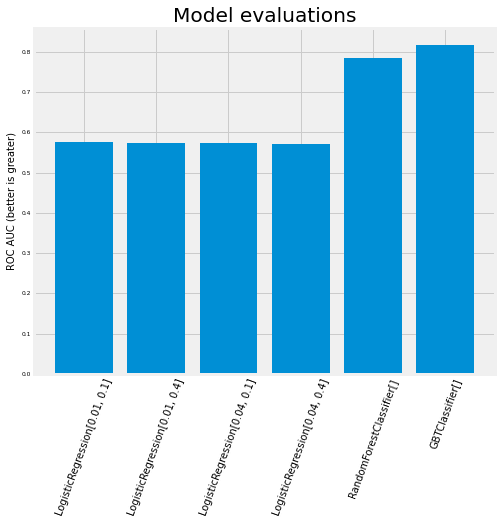

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.clf() # clear figure
fig = plt.figure( figsize=(8, 8))
plt.style.use('fivethirtyeight')
axis = fig.add_axes([0.1, 0.3, 0.8, 0.6])
# plot the metrics as Y
#plt.plot(range(len(model_names)),metrics)
plt.bar(range(len(model_names)),metrics)
# plot the model name & param as X labels
plt.xticks(range(len(model_names)), model_names, rotation=70, fontsize=10)
plt.yticks(fontsize=6)
#plt.xlabel('model',fontsize=8)
plt.ylabel('ROC AUC (better is greater)',fontsize=10)
plt.title('Model evaluations')
display(plt.show())

In [0]:
best_model = cvModel.bestModel
lm = best_model.stages[-1]

###  Confusion Matrix

DenseMatrix([[2390083.,   24307.],
             [1524039.,   33710.]])


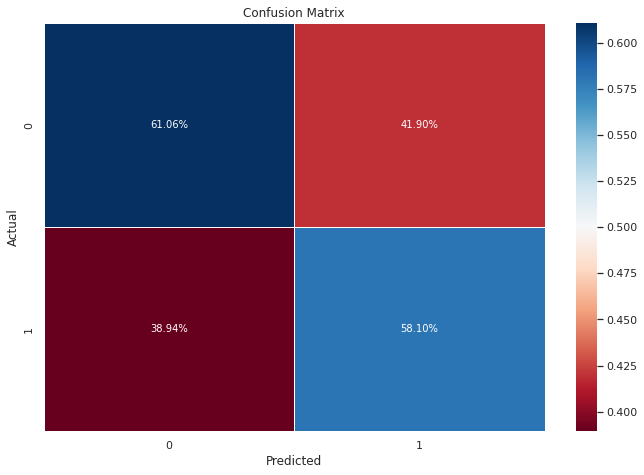

In [0]:
from pyspark.mllib.evaluation import MulticlassMetrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette("bright")

predictions = best_model.transform(train_data)
#predictions.filter(F.col('label').isNull() | F.col('prediction').isNull()).show()


# Confusion matrix from labels and predictions
metrics = MulticlassMetrics(predictions.select('label', 'prediction').rdd.map(tuple))
print(metrics.confusionMatrix())
confusion_matrix = metrics.confusionMatrix().toArray()

# Pandas DataFrame from Spark confusion matrix
cnf_matrix = pd.DataFrame(confusion_matrix)

plt.figure(figsize = (10,7))
p = sns.heatmap(cnf_matrix/np.sum(cnf_matrix), annot=True, fmt=".2%", linewidth=0.5, annot_kws={'fontsize':10}, cmap='RdBu')
# If you want numbers, instead of percent
# p = sns.heatmap(cnf_matrix, annot=True, fmt=",.1f", linewidth=0.5, annot_kws={'fontsize':10}, cmap='RdBu');

p.set(xlabel='Predicted', ylabel='Actual', title='Confusion Matrix');

### Model Behaviour?

The model seems to be struggling to make accurate prediction on cancellation of flights. Despite running the model with balancing weights and cross validation the performance seems to inadequate. 
Following can be the reasons for such behaviour - 

#### Feature Representation:
* Insufficient or irrelevant features might affect the model's ability to capture patterns related to flight cancellations 
  accurately. Ensure that the features used in training the model are relevant and provide enough information to distinguish between the classes.


#### Complexity of the Cancellation Pattern:
* The behavior of flight cancellations is complex and multifaceted, involving a combination of factors. This dataset does not 
  encompass a sufficiently diverse range of scenarios and conditions leading to cancellations, 
  so the model is struggling to discern and learn the intricate patterns characterizing this class.

### Business Use Cases
##### Operational Efficiency:###
 * Airlines can optimize crew schedules and resources with advance cancellation predictions, reducing costs.
 * Ground services benefit from better planning, minimizing downtime during potential cancellations.

##### Customer Service:##### 
 * Travel agencies can alert customers early about potential cancellations, enabling proactive changes to travel plans.
 * Airlines providing timely information to affected passengers enhance overall customer satisfaction.

##### Revenue Management:#####
 * Airlines adjust pricing based on predicted cancellations, optimizing revenue and seat allocation.
 * Dynamic pricing by travel agencies aligns with cancellation probabilities for accurate cost projections.


##### Supply Chain Management:#####
 * Cargo-dependent companies benefit from predicting cancellations, allowing better supply chain logistics planning.
 * Manufacturers adjust production schedules based on likely delays in receiving goods due to cancellations.